In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #disable tensorflow warnings

In [3]:

def read_from_source():
    df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
    df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
    df['Date'] = pd.to_datetime(df['Date'])
    return df



def pred_covid(model_name, df, model_idx): #GRU or LSTM
    #model = load_model('../'+model_name +'_infected_only_GRU_LSTM_Oct16.h5') #best
    model = load_model('LSTM_GRU_Oct23_relu/' + model_name +'_infected_only_Oct23_'+str(model_idx)+'.h5')
    print(model_name,'loaded')

    #constant
    n_steps_in = 14
    n_steps_out = 4
    sc = MinMaxScaler(feature_range = (0, 1))
    
    x_input = df['Infected'][-n_steps_in:].values # last 14 day
    x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
    x_input = x_input.reshape((1, n_steps_in, 1))
    
    #y_pred = model.predict(x_input) # too much warnings
    y_pred = model(x_input)
    y_pred = sc.inverse_transform(y_pred) #revert scaling
    #print('Next 4 days prediction:', y_pred)
    
    start_date = str(df['Date'].iloc[-14])[:10]
    end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
    end_date = str(end_date)[:10]
    #print(start_date,'---', end_date)
    time_range = pd.date_range(start=start_date, end=end_date)
    
    pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred[0,:]))
    return pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

In [4]:
df = read_from_source()
df = df.append({'Date':pd.to_datetime('2021-10-31'),'Infected':4284}, ignore_index = True) #anomaly
df = df.append({'Date':pd.to_datetime('2021-11-01'),'Infected':5000}, ignore_index = True) #anomaly
df = df.append({'Date':pd.to_datetime('2021-11-02'),'Infected':354}, ignore_index = True) #anomaly

df

,Date,Infected
0,2020-01-16,1.0
1,2020-01-17,0.0
2,2020-01-18,0.0
3,2020-01-19,0.0
4,2020-01-20,0.0
...,...,...
652,2021-10-29,291.0
653,2021-10-30,283.0
654,2021-10-31,4284.0
655,2021-11-01,5000.0


In [5]:
df[-14:]

,Date,Infected
643,2021-10-20,387.0
644,2021-10-21,334.0
645,2021-10-22,324.0
646,2021-10-23,277.0
647,2021-10-24,229.0
648,2021-10-25,147.0
649,2021-10-26,309.0
650,2021-10-27,310.0
651,2021-10-28,268.0
652,2021-10-29,291.0


In [6]:
pred_covid('GRU', df,1)

GRU loaded


,Date,Predict Infected
0,2021-11-03,1100.491580
1,2021-11-04,5016.287149
2,2021-11-05,3541.818538
3,2021-11-06,4303.531585


In [7]:
def get_prediction(model, df): #model = 'GRU' or 'LSTM'
    pred_arr = []
    for model_idx in [1,2,3]:
        #print(model,model_idx,pred_covid(model, df,model_idx))
        pred_arr.append(np.array(pred_covid(model, df,model_idx)['Predict Infected'].values))
    return np.array(pred_arr)

In [8]:
def get_PI(pred_arr):
    intervals = []
    means = []
    uppers = []
    lowers = []
    for idx in [0,1,2,3]:
        cov_std = pred_arr[:,idx].std()
        cov_interval = cov_std*1.96
        cov_mean = pred_arr[:,idx].mean()
        cov_lower = cov_mean - cov_interval
        if (cov_lower<0):
            cov_lower = 0
        cov_upper = cov_mean + cov_interval
        print(pred_arr[:,idx], 'Interval: ',cov_interval , 'Lower: ',cov_lower, 'Mean: ',cov_mean, 'Upper: ',cov_upper)
        
        intervals.append(int(cov_interval))
        means.append(int(cov_mean))
        uppers.append(int(cov_upper))
        lowers.append(int(cov_lower))
    
    return intervals, means, uppers, lowers

In [9]:
%%time
model_type = 'GRU'
GRU_pred_arr = get_prediction(model_type,df)
cov_intervals, cov_means, cov_uppers, cov_lowers = get_PI(GRU_pred_arr)


GRU loaded
GRU loaded
GRU loaded
[1100.49158013 2668.14052558 1041.77622838] Interval:  1476.3066057754763 Lower:  127.16283892162551 Mean:  1603.4694446971018 Upper:  3079.7760504725784
[5016.28714907 3295.90011621 5963.52952719] Interval:  2164.2248584164795 Lower:  2594.3474057382723 Mean:  4758.572264154752 Upper:  6922.797122571232
[3541.81853795 3018.67088985 5443.60482895] Interval:  2042.2053778887437 Lower:  1959.159374364153 Mean:  4001.364752252897 Upper:  6043.57013014164
[4303.5315845  3615.63311476 3295.93714166] Interval:  823.9920141068914 Lower:  2914.3752661975404 Mean:  3738.367280304432 Upper:  4562.359294411323
Wall time: 4.89 s


In [10]:
GRU_pred_arr

array([[1100.49158013, 5016.28714907, 3541.81853795, 4303.5315845 ],
       [2668.14052558, 3295.90011621, 3018.67088985, 3615.63311476],
       [1041.77622838, 5963.52952719, 5443.60482895, 3295.93714166]])

In [11]:
cov_intervals

[1476, 2164, 2042, 823]

In [12]:
cov_means

[1603, 4758, 4001, 3738]

In [13]:
y = cov_means


In [14]:
start_date = str(df[-14:]['Date'].iloc[0])[:10]
start_date

'2021-10-20'

In [15]:
end_date = pred_covid('GRU', df,3)['Date'][3]
end_date

GRU loaded


'2021-11-06'

In [16]:
time_range = pd.date_range(start = start_date, end= end_date)


In [17]:
time_range[:-4]

DatetimeIndex(['2021-10-20', '2021-10-21', '2021-10-22', '2021-10-23',
               '2021-10-24', '2021-10-25', '2021-10-26', '2021-10-27',
               '2021-10-28', '2021-10-29', '2021-10-30', '2021-10-31',
               '2021-11-01', '2021-11-02'],
              dtype='datetime64[ns]', freq='D')

In [18]:
len(time_range)

18

In [19]:
cov_intervals

[1476, 2164, 2042, 823]

In [20]:
y[0]

1603

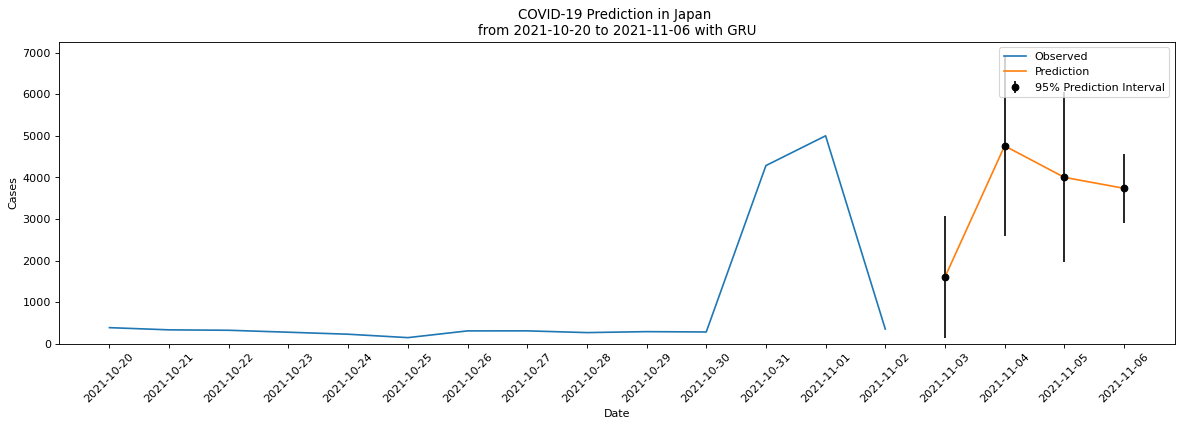

In [21]:
from matplotlib.pyplot import figure
figure(figsize=(18, 5), dpi=80)

plt.plot(time_range[:-4],df['Infected'][-14:], label='Observed')
plt.plot(time_range[-4:],y, label='Prediction')

plt.errorbar(time_range[-4], y[0], yerr=cov_intervals[0], color='black', fmt='o', label='95% Prediction Interval')
plt.errorbar(time_range[-3], y[1], yerr=cov_intervals[1], color='black', fmt='o')
plt.errorbar(time_range[-2], y[2], yerr=cov_intervals[2], color='black', fmt='o')
plt.errorbar(time_range[-1], y[3], yerr=cov_intervals[3], color='black', fmt='o')

plt.xlabel('Date')
plt.ylabel('Cases')
plt.xticks(time_range,rotation=45)
plt.title('COVID-19 Prediction in Japan \nfrom {0} to {1} with {2}'.format(start_date, end_date, model_type))
plt.legend()
plt.ylim(0, None) # Or similarly "plt.ylim(0)" #important

plt.show()